# AutoEncoder CelebA Dataset

In [1]:
# !pip install scikit-image

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# from skimage.metrics import peak_signal_noise_ratio as psnr
# from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda


# Data Exploration

In [3]:
# Path to your image
image_path = './data/RealBlur_J/train/blur/10.png'

# Open the image
image = Image.open(image_path)

# Get the size of the image
size = image.size

# Print the size (Width, Height)
print("Image Size: ", size)

# To get the shape, especially if you plan to work with PyTorch, you'll likely need the channels as well
# PIL Images are in Width x Height format. For the shape, we usually want channels as well,
# which for RGB images is 3. PyTorch uses Channels x Height x Width format.
shape = (3, image.height, image.width)

# Print the shape
print("Image Shape: ", shape)

Image Size:  (669, 762)
Image Shape:  (3, 762, 669)


In [4]:
class CelebADeblurDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            split (string): One of 'train', 'validation', 'test' to select the dataset split.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.blur_dir = os.path.join(self.root_dir, 'blur')
        self.sharp_dir = os.path.join(self.root_dir, 'sharp')
        self.image_files = os.listdir(self.blur_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        blur_img_path = os.path.join(self.blur_dir, self.image_files[idx])
        sharp_img_path = os.path.join(self.sharp_dir, self.image_files[idx])

        blur_image = Image.open(blur_img_path).convert('RGB')
        sharp_image = Image.open(sharp_img_path).convert('RGB')

        if self.transform:
            blur_image = self.transform(blur_image)
            sharp_image = self.transform(sharp_image)

        return blur_image, sharp_image

In [5]:
# Define your transforms (adjust as necessary)
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the images to 256x256
    transforms.ToTensor(),
])

# Instantiate your dataset
root_dir = './data/RealBlur_J'
train_dataset = CelebADeblurDataset(root_dir=root_dir, split='train', transform=transform)
# validation_dataset = CelebADeblurDataset(root_dir=root_dir, split='validation', transform=transform)
# test_dataset = CelebADeblurDataset(root_dir=root_dir, split='test', transform=transform)

# Load the datasets into DataLoader for efficient batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

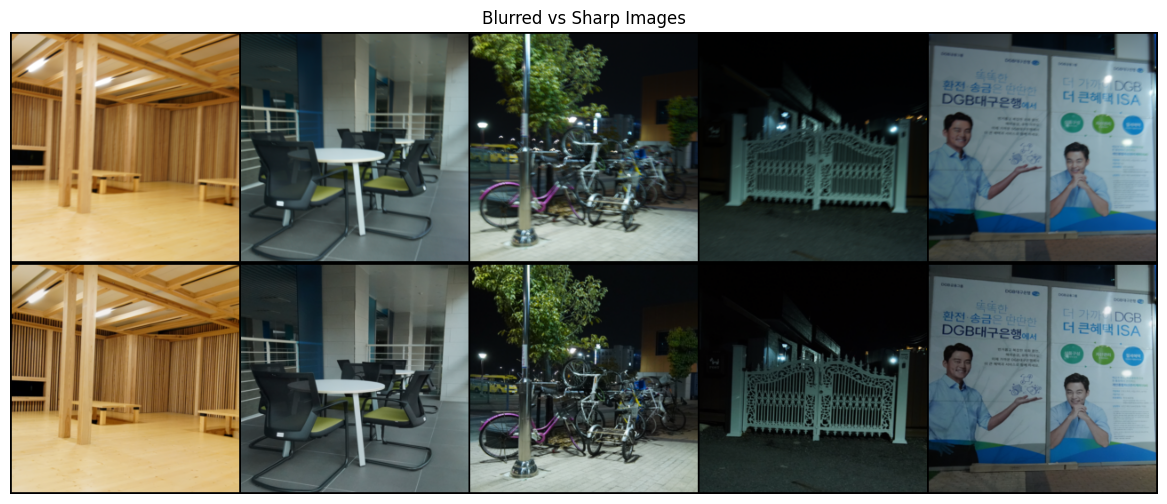

In [6]:
def imshow_grid(blurred_images, sharp_images, n_images=5, title=None):
    """Function to show n pairs of blurred and sharp images"""
    # Assuming `blurred_images` and `sharp_images` are batches of images
    # Select the first `n_images`
    blurred_images = blurred_images[:n_images]
    sharp_images = sharp_images[:n_images]
    
    # Make a grid for blurred and sharp images
    blurred_grid = torchvision.utils.make_grid(blurred_images, nrow=n_images)
    sharp_grid = torchvision.utils.make_grid(sharp_images, nrow=n_images)
    
    # Convert to numpy arrays for plotting
    np_blurred_grid = blurred_grid.numpy()
    np_sharp_grid = sharp_grid.numpy()
    
    # Concatenate grids along height (axis=1 for Height in HWC format after transpose)
    combined_grid = np.concatenate((np.transpose(np_blurred_grid, (1, 2, 0)), np.transpose(np_sharp_grid, (1, 2, 0))), axis=0)
    
    plt.figure(figsize=(15, 6))  # Adjust size as needed
    plt.imshow(combined_grid)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()
    
# To visualize the first few pairs of images
blurred_images, sharp_images = next(iter(train_loader))

# Visualizing the first image pair as an example
imshow_grid(blurred_images, sharp_images, n_images=5, title="Blurred vs Sharp Images")

# Autoencoder Model

In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = self.init_encoder()
        self.decoder = self.init_decoder()

    def init_encoder(self):
        """
        Initializes the encoder part of the autoencoder with 4 convolutional layers.
        """
        encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # Output: (16, 128, 128)
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # Output: (32, 64, 64)
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 32, 32)
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # Output: (128, 16, 16)
            nn.ReLU(True),
        )
        return encoder

    def init_decoder(self):
        """
        Initializes the decoder part of the autoencoder with 4 convolutional layers.
        """
        decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # Output: (64, 32, 32)
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: (32, 64, 64)
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: (16, 128, 128)
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: (3, 256, 256)
            nn.Sigmoid()  # Use sigmoid to scale the output to [0,1]
        )
        return decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def fit(self, train_loader, epochs=10, learning_rate=1e-3, weight_decay=1e-5, loss_fn=nn.MSELoss(), verbose=False):
        optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.to(device)
        results = []  # List to store outputs for visualization
        
        for epoch in range(epochs):
            self.train()  # Set model to training mode
            train_loss = 0.0
            for data in train_loader:
                inputs, targets = data
                inputs, targets = inputs.to(device), targets.to(device)

                optimizer.zero_grad()
                outputs = self(inputs)
                loss = loss_fn(outputs, targets)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            train_loss /= len(train_loader)

            if verbose:
#                 self.eval()  # Set the model to evaluation mode
#                 with torch.no_grad():  # Inference mode, gradient not computed
#                     validation_loss = 0.0
#                     for data in validation_loader:
#                         inputs, targets = data
#                         inputs, targets = inputs.to(device), targets.to(device)
#                         outputs = self(inputs)
#                         loss = loss_fn(outputs, targets)
#                         validation_loss += loss.item()
#                     validation_loss /= len(validation_loader)

                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}")
            
            # Store outputs along with epoch number for visualization
            if epoch % 4 == 0:  # Adjust as per your requirement
                results.append((epoch, inputs.cpu(), outputs.cpu()))
                
        return outputs

    def visualize_reconstructions(self, outputs, n=5):
        """
        Visualizes original and reconstructed images.
        """
        for epoch, imgs, recons in outputs:
            plt.figure(figsize=(10, 2))
            for i in range(n):
                if i >= len(imgs): break
                plt.subplot(2, n, i + 1)
                plt.imshow(imgs[i].permute(1, 2, 0))
                plt.axis('off')
                
                plt.subplot(2, n, n + i + 1)
                plt.imshow(recons[i].permute(1, 2, 0))
                plt.axis('off')
            plt.suptitle(f'Epoch: {epoch}')
            plt.show()

## Train Model

In [8]:
# Instantiate the autoencoder model
model = Autoencoder().to(device)

model.load_state_dict(torch.load('./autoencoder_model_full4.pth'))

# Train the model
num_epochs = 20  # You can adjust the number of epochs
outputs = model.fit(train_loader, epochs=num_epochs, verbose=True)

Epoch 1/20, Train Loss: 0.0097
Epoch 2/20, Train Loss: 0.0042
Epoch 3/20, Train Loss: 0.0034
Epoch 4/20, Train Loss: 0.0031
Epoch 5/20, Train Loss: 0.0030
Epoch 6/20, Train Loss: 0.0029
Epoch 7/20, Train Loss: 0.0028
Epoch 8/20, Train Loss: 0.0028
Epoch 9/20, Train Loss: 0.0028
Epoch 10/20, Train Loss: 0.0028
Epoch 11/20, Train Loss: 0.0028
Epoch 12/20, Train Loss: 0.0027
Epoch 13/20, Train Loss: 0.0028
Epoch 14/20, Train Loss: 0.0028
Epoch 15/20, Train Loss: 0.0027
Epoch 16/20, Train Loss: 0.0028
Epoch 17/20, Train Loss: 0.0028
Epoch 18/20, Train Loss: 0.0028
Epoch 19/20, Train Loss: 0.0027
Epoch 20/20, Train Loss: 0.0027


In [9]:
# Save the model's state dictionary
model_save_path = './autoencoder_model_full5.pth'
torch.save(model.state_dict(), model_save_path)

In [10]:
# Visualize the reconstructions
# model.visualize_reconstructions(outputs[-1], n=5)

In [11]:
def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No gradients needed
        total_mse, total_psnr, total_ssim = 0, 0, 0
        for batch in test_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            mse = nn.MSELoss()(outputs, targets).item()
            total_mse += mse
            
            for i in range(outputs.size(0)):
                output_np = outputs[i].squeeze().cpu().numpy().transpose(1, 2, 0)
                target_np = targets[i].squeeze().cpu().numpy().transpose(1, 2, 0)
                total_psnr += psnr(target_np, output_np, data_range=1)
                total_ssim += ssim(target_np, output_np, multichannel=True, data_range=1)
        
        # Average metrics
        avg_mse = total_mse / len(test_loader)
        avg_psnr = total_psnr / (len(test_loader) * test_loader.batch_size)
        avg_ssim = total_ssim / (len(test_loader) * test_loader.batch_size)
        
        print(f"Test MSE: {avg_mse:.4f}, PSNR: {avg_psnr:.4f}, SSIM: {avg_ssim:.4f}")

# Evaluate the model
evaluate_model(model, test_loader)

NameError: name 'test_loader' is not defined